# <p align=center> Produire une étude de marché avec Python 2/2 <p>

## <p align=center> Clustering et Visualisations <p>

<p align=center><img src="https://user.oc-static.com/upload/2020/11/24/16062164030098_image2.png" alt="Logo Poule Qui Chante" width="500" title=""><p>

Pour finaliser l'étude, nous allons maintenant utiliser différentes méthodes de clustering afin de sélectionner les pays d'interêt.

In [1]:
#Import des Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Gestion des warnings
import warnings
warnings.simplefilter("ignore")

#CAH "La classification ascendante hiérarchique"
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler

#Kmeans
from sklearn import cluster
from sklearn.cluster import KMeans

#Décomposition en composante principade
from sklearn.decomposition import PCA

#Visualisation sur une carte
import geopandas


In [2]:
#Définitions des fonctions

#Cercle de Corrélation
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

   
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    #On ajoute les centroids obtenus avec le Kmeans        
    # plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1],s=200,marker='*', c='red', alpha=0.7, label='Centroids')
    
    # Axes et display
    plt.axis('equal')
    plt.show(block=False)
    
    
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
                for i,(_x,_y) in enumerate(X_[:,[x,y]]):
                    plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 
    #On ajoute les centroids obtenus avec le Kmeans        
    plt.scatter(km.cluster_centers_[:, x], km.cluster_centers_[:,y],s=200,marker='*', c='red', alpha=0.7, label='Centroids')
    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()


In [3]:
df_full = pd.read_csv('data.csv').set_index('Zone')

In [4]:
df_full.head()

,Autosuffisance,part Import,Population,Evolution de la population 2013-2017,Disponibilité alimentaire (Kcal/personne/jour),Part Poulet,PIB par habitant,Evolution du PIB 2013-2017,Evolution des importation 2013-2017,Evolution de la consommation 2013-2017,Index Stabilité
Zone,,,,,,,,,,,
Afghanistan,49.122807,50.877193,36296113.0,11.093541,5.0,11.894273,530.149831,17.344283,24.281558,4.718645,-2.80
Afrique du Sud,78.706327,24.268178,57009756.0,5.828187,143.0,49.163763,6723.928582,10.612243,-11.235664,-6.082222,-0.28
Albanie,27.659574,80.851064,2884169.0,-0.680300,85.0,23.838538,4521.752219,-2.130179,27.708662,28.553922,0.38
Algérie,99.277978,0.722022,41389189.0,7.850011,22.0,20.061100,4134.936054,33.491244,-0.995118,-0.995950,-0.92
Allemagne,87.061530,48.418631,82658409.0,1.795391,71.0,21.790309,44670.222288,2.303657,-11.105807,-2.543802,0.59


In [5]:
#Nous ne gardons que les valeurs d'interet
df_full.fillna(value=0, inplace=True)
df = df_full.copy()
df.drop(columns=['Population','Evolution du PIB 2013-2017','Evolution de la consommation 2013-2017','Disponibilité alimentaire (Kcal/personne/jour)','Index Stabilité','Part Poulet'],inplace=True)


In [6]:
df.head()

,Autosuffisance,part Import,Evolution de la population 2013-2017,PIB par habitant,Evolution des importation 2013-2017
Zone,,,,,
Afghanistan,49.122807,50.877193,11.093541,530.149831,24.281558
Afrique du Sud,78.706327,24.268178,5.828187,6723.928582,-11.235664
Albanie,27.659574,80.851064,-0.680300,4521.752219,27.708662
Algérie,99.277978,0.722022,7.850011,4134.936054,-0.995118
Allemagne,87.061530,48.418631,1.795391,44670.222288,-11.105807


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, Afghanistan to Îles Salomon
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Autosuffisance                        172 non-null    float64
 1   part Import                           172 non-null    float64
 2   Evolution de la population 2013-2017  172 non-null    float64
 3   PIB par habitant                      172 non-null    float64
 4   Evolution des importation 2013-2017   172 non-null    float64
dtypes: float64(5)
memory usage: 8.1+ KB


In [8]:
features = df.columns

## 1.Classification Hierarchique Ascendante

In [9]:
#extraire les valeurs numériques du dataset
X = df.values


In [10]:
#Choix du Scaler
scaler=StandardScaler()
#Application aux données
scaler.fit(X)

X_scaled = scaler.transform(X)



In [11]:
#Vérification du scaling
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4
mean,-0.0,-0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0


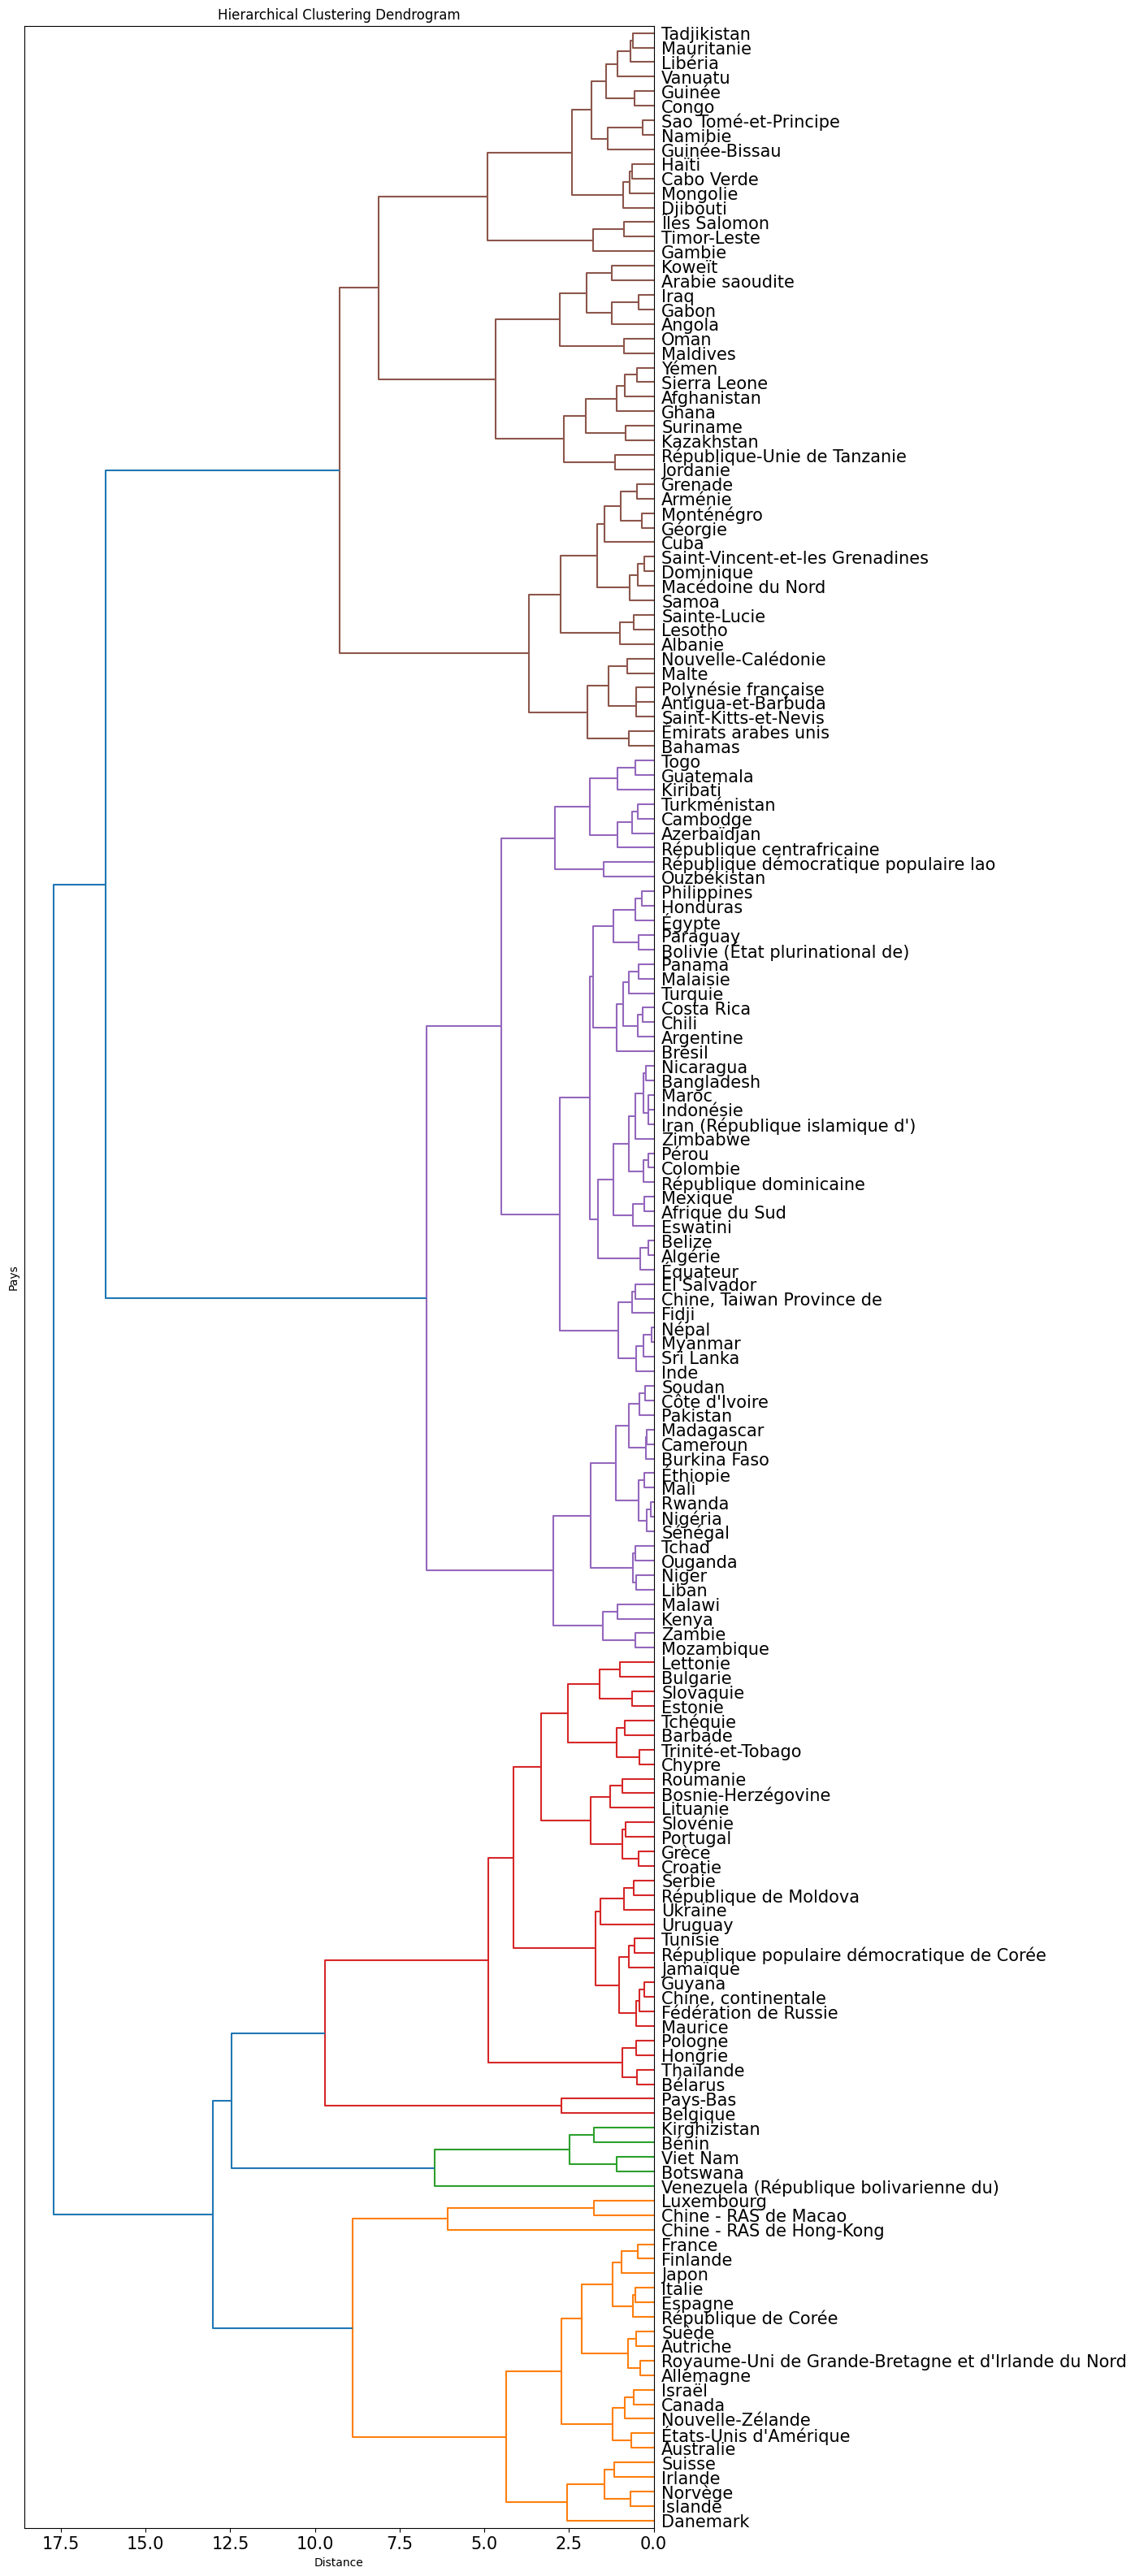

In [12]:
#Linkage par la méthode de Ward
Z=sch.linkage(X_scaled, method='ward', metric='euclidean')


fig, ax = plt.subplots(1, 1, figsize=(10,40))
#generer le dendrogramme 

dendrogram = sch.dendrogram(Z, labels = df.index,orientation = "left")

plt.title("Hierarchical Clustering Dendrogram")
ax.set_xlabel("Distance")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

In [13]:
# utiliser  AgglomerativeClustering pour determiner le contenu des clusters.
agg_clustering = AgglomerativeClustering(n_clusters=5)
#appliquer l'algorithme sur mes données
agg_clustering.fit(X_scaled)
#creer une colonne pour mettre les clusters generés
df['CHA Clusters'] = agg_clustering.labels_
df_full['CHA Clusters'] = agg_clustering.labels_
df.head()

,Autosuffisance,part Import,Evolution de la population 2013-2017,PIB par habitant,Evolution des importation 2013-2017,CHA Clusters
Zone,,,,,,
Afghanistan,49.122807,50.877193,11.093541,530.149831,24.281558,1
Afrique du Sud,78.706327,24.268178,5.828187,6723.928582,-11.235664,2
Albanie,27.659574,80.851064,-0.680300,4521.752219,27.708662,1
Algérie,99.277978,0.722022,7.850011,4134.936054,-0.995118,2
Allemagne,87.061530,48.418631,1.795391,44670.222288,-11.105807,3


In [14]:
# comprendre la caracterisation des clusters
df.groupby(['CHA Clusters']).mean()


,Autosuffisance,part Import,Evolution de la population 2013-2017,PIB par habitant,Evolution des importation 2013-2017
CHA Clusters,,,,,
0,122.836907,38.729653,-0.115542,12664.441630,-3.684816
1,23.730212,92.846254,6.763611,8326.453619,-9.387126
2,92.020930,9.374685,6.864933,4056.886511,-20.227704
3,87.329669,47.750139,3.029138,54205.865033,-5.364937
4,55.289949,45.100524,5.425066,3910.171722,95.200886


In [15]:
#Création de la liste des pays par cluster
for i in range(5):
    print(f'Cluster {i} : {len(df[df["CHA Clusters"] == i])} pays')
    print(df[df['CHA Clusters'] == i].index.tolist())
    print()

Cluster 0 : 32 pays
['Barbade', 'Belgique', 'Bosnie-Herzégovine', 'Bulgarie', 'Bélarus', 'Chine, continentale', 'Chypre', 'Croatie', 'Estonie', 'Fédération de Russie', 'Grèce', 'Guyana', 'Hongrie', 'Jamaïque', 'Lettonie', 'Lituanie', 'Maurice', 'Pays-Bas', 'Pologne', 'Portugal', 'Roumanie', 'République de Moldova', 'République populaire démocratique de Corée', 'Serbie', 'Slovaquie', 'Slovénie', 'Tchéquie', 'Thaïlande', 'Trinité-et-Tobago', 'Tunisie', 'Ukraine', 'Uruguay']

Cluster 1 : 50 pays
['Afghanistan', 'Albanie', 'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Arménie', 'Bahamas', 'Cabo Verde', 'Congo', 'Cuba', 'Djibouti', 'Dominique', 'Gabon', 'Gambie', 'Ghana', 'Grenade', 'Guinée', 'Guinée-Bissau', 'Géorgie', 'Haïti', 'Iraq', 'Jordanie', 'Kazakhstan', 'Koweït', 'Lesotho', 'Libéria', 'Macédoine du Nord', 'Maldives', 'Malte', 'Mauritanie', 'Mongolie', 'Monténégro', 'Namibie', 'Nouvelle-Calédonie', 'Oman', 'Polynésie française', 'République-Unie de Tanzanie', 'Saint-Kitts-et-N

## 2. K-means

In [16]:
res = cluster.KMeans(n_clusters=4)
res.fit(X_scaled)

KMeans(n_clusters=4)

KElbowVisualizer(ax=<AxesSubplot: >, estimator=KMeans(n_clusters=9), k=(1, 10),
                 timings=False)

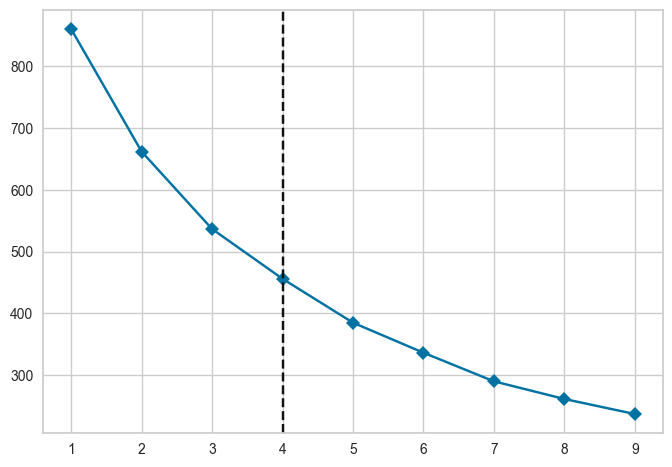

In [17]:
from yellowbrick.cluster import KElbowVisualizer
coude = KElbowVisualizer(res,k=(1,10),timings=False)
coude.fit(X_scaled)

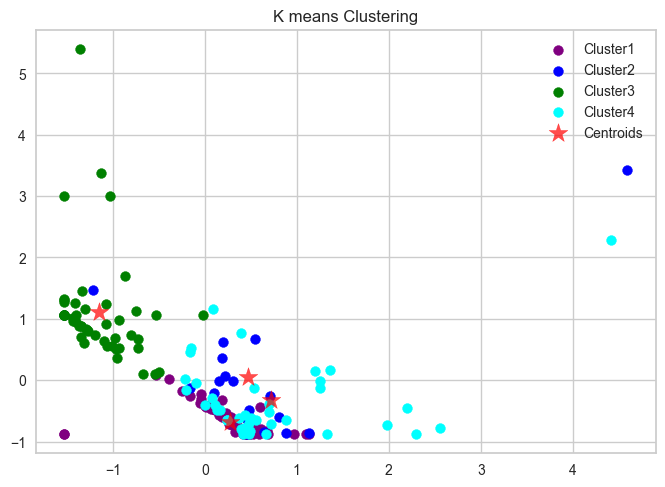

In [18]:

#Application du Kmeans avec k=4
km=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)


y_means = km.fit_predict(X_scaled)#Visualizing the clusters for k=4
plt.scatter(X_scaled[y_means==0,0],X_scaled[y_means==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(X_scaled[y_means==1,0],X_scaled[y_means==1,1],s=50, c='blue',label='Cluster2')
plt.scatter(X_scaled[y_means==2,0],X_scaled[y_means==2,1],s=50, c='green',label='Cluster3')
plt.scatter(X_scaled[y_means==3,0],X_scaled[y_means==3,1],s=50, c='cyan',label='Cluster4')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1],s=200,marker='*', c='red', alpha=0.7, label='Centroids')
plt.title('K means Clustering')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

In [19]:
print(km.cluster_centers_)

[[ 0.27940964 -0.67677035  0.55227913 -0.5133872  -0.35527558]
 [ 0.47163639  0.05158182 -0.36550106  2.31557038  0.04134205]
 [-1.15105432  1.10637392  0.33549846 -0.22339051  0.05759169]
 [ 0.72306186 -0.3240048  -1.05782218 -0.086226    0.44825006]]


In [20]:
df.loc[:,"cluster Kmeans"] = km.labels_
df_full.loc[:,"cluster Kmeans"] = km.labels_

In [21]:
df.head()

,Autosuffisance,part Import,Evolution de la population 2013-2017,PIB par habitant,Evolution des importation 2013-2017,CHA Clusters,cluster Kmeans
Zone,,,,,,,
Afghanistan,49.122807,50.877193,11.093541,530.149831,24.281558,1,2
Afrique du Sud,78.706327,24.268178,5.828187,6723.928582,-11.235664,2,0
Albanie,27.659574,80.851064,-0.680300,4521.752219,27.708662,1,2
Algérie,99.277978,0.722022,7.850011,4134.936054,-0.995118,2,0
Allemagne,87.061530,48.418631,1.795391,44670.222288,-11.105807,3,1


In [22]:
#Analyse des clusters Kmeans
df.groupby(['cluster Kmeans']).mean()

,Autosuffisance,part Import,Evolution de la population 2013-2017,PIB par habitant,Evolution des importation 2013-2017,CHA Clusters
cluster Kmeans,,,,,,
0,90.100663,10.329633,7.423659,3837.814540,-17.944830,1.935484
1,99.659082,47.934372,3.366103,57637.475663,-7.574739,2.850000
2,18.971264,102.393168,6.465260,9352.822465,-7.149871,1.163265
3,112.161139,28.542878,0.305314,11961.346722,3.064409,0.707317


In [23]:
for i in range(4):
    print(f'Cluster {i} : {len(df[df["cluster Kmeans"] == i])} pays')
    print(df[df['cluster Kmeans'] == i].index.tolist())
    print()

Cluster 0 : 62 pays
['Afrique du Sud', 'Algérie', 'Argentine', 'Azerbaïdjan', 'Bangladesh', 'Belize', 'Bolivie (État plurinational de)', 'Burkina Faso', 'Cambodge', 'Cameroun', 'Chili', 'Colombie', 'Costa Rica', "Côte d'Ivoire", 'Eswatini', 'Guatemala', 'Honduras', 'Inde', 'Indonésie', "Iran (République islamique d')", 'Jordanie', 'Kenya', 'Kiribati', 'Liban', 'Madagascar', 'Malaisie', 'Malawi', 'Mali', 'Maroc', 'Mexique', 'Mozambique', 'Myanmar', 'Nicaragua', 'Niger', 'Nigéria', 'Népal', 'Ouganda', 'Ouzbékistan', 'Pakistan', 'Panama', 'Paraguay', 'Philippines', 'Pérou', 'Rwanda', 'République centrafricaine', 'République dominicaine', 'République démocratique populaire lao', 'République-Unie de Tanzanie', 'Sierra Leone', 'Soudan', 'Sri Lanka', 'Sénégal', 'Tchad', 'Togo', 'Turkménistan', 'Turquie', 'Yémen', 'Zambie', 'Zimbabwe', 'Égypte', 'Équateur', 'Éthiopie']

Cluster 1 : 20 pays
['Allemagne', 'Australie', 'Autriche', 'Belgique', 'Canada', 'Chine - RAS de Macao', 'Danemark', 'Finland

## 3. ACP

In [24]:
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=5)

In [25]:
pca.explained_variance_ratio_

array([0.31357388, 0.25901358, 0.19148162, 0.14191864, 0.09401228])

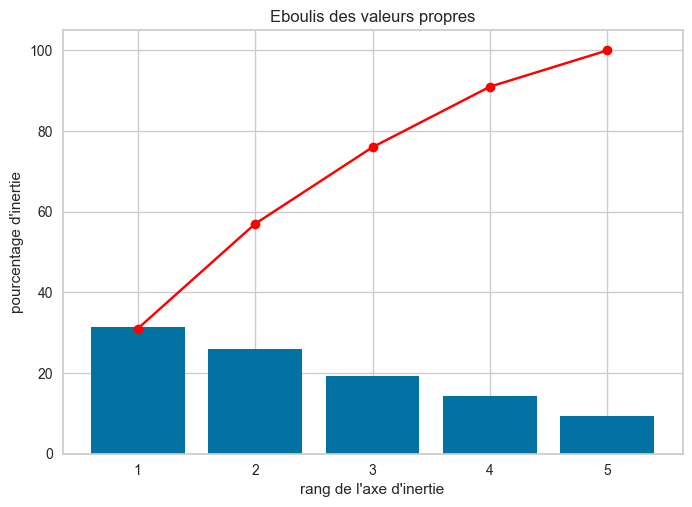

In [26]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)
list(x_list)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

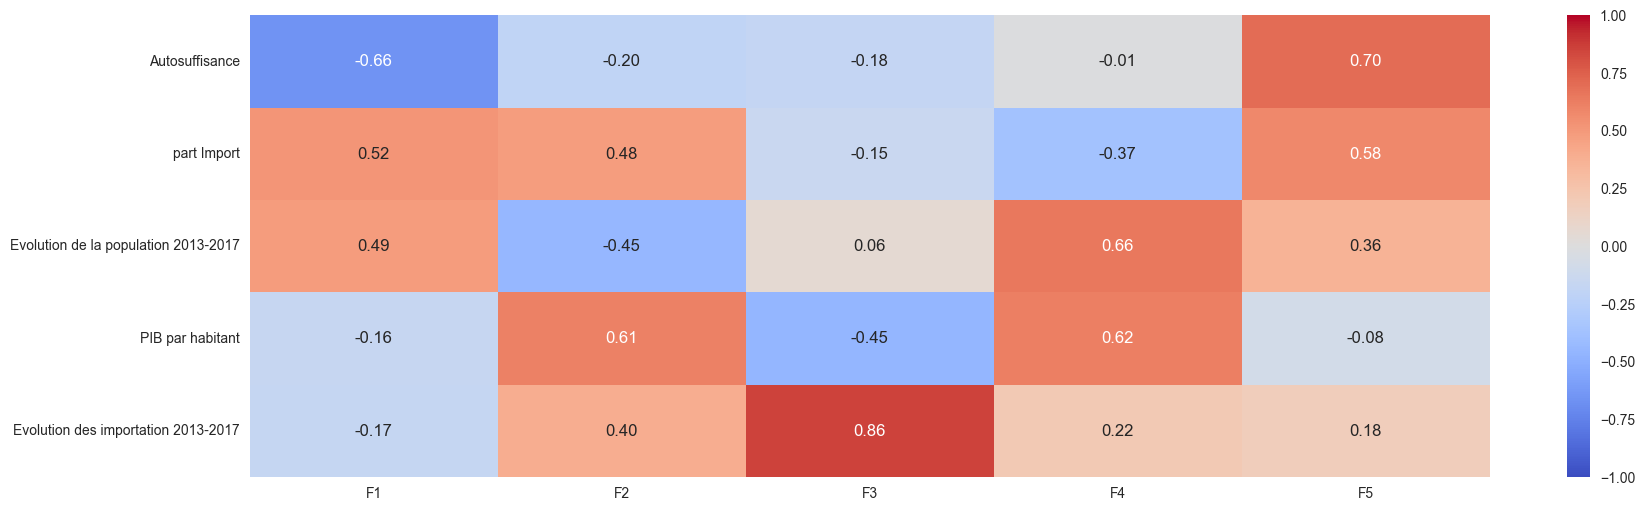

In [27]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)
pcs.T

fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.show()

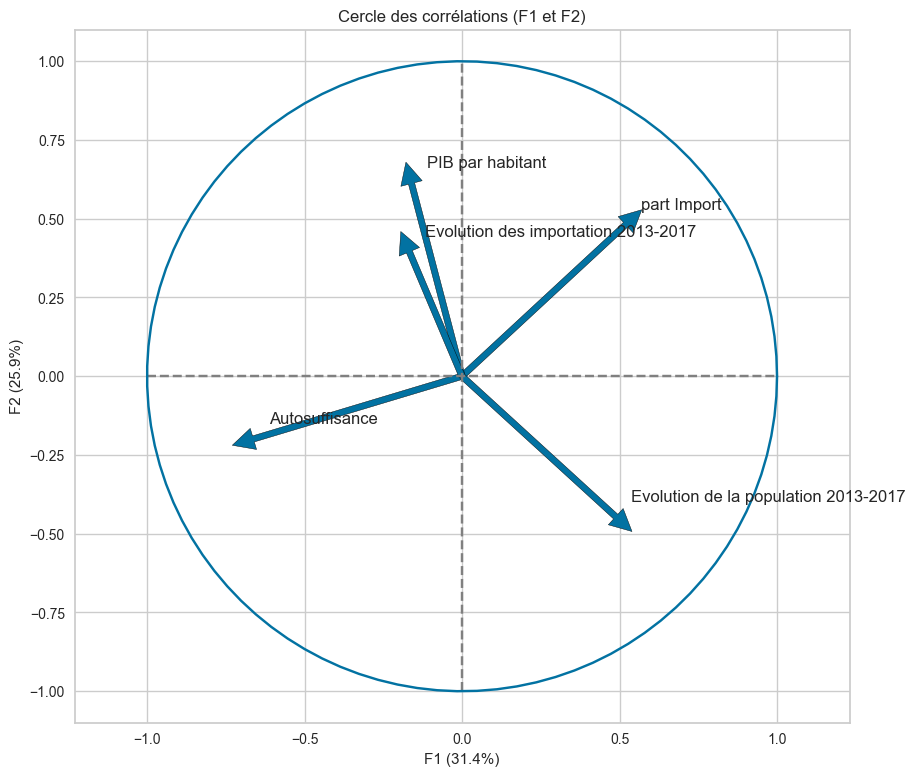

In [28]:
x_y = [0,1]
correlation_graph(pca, x_y, features)

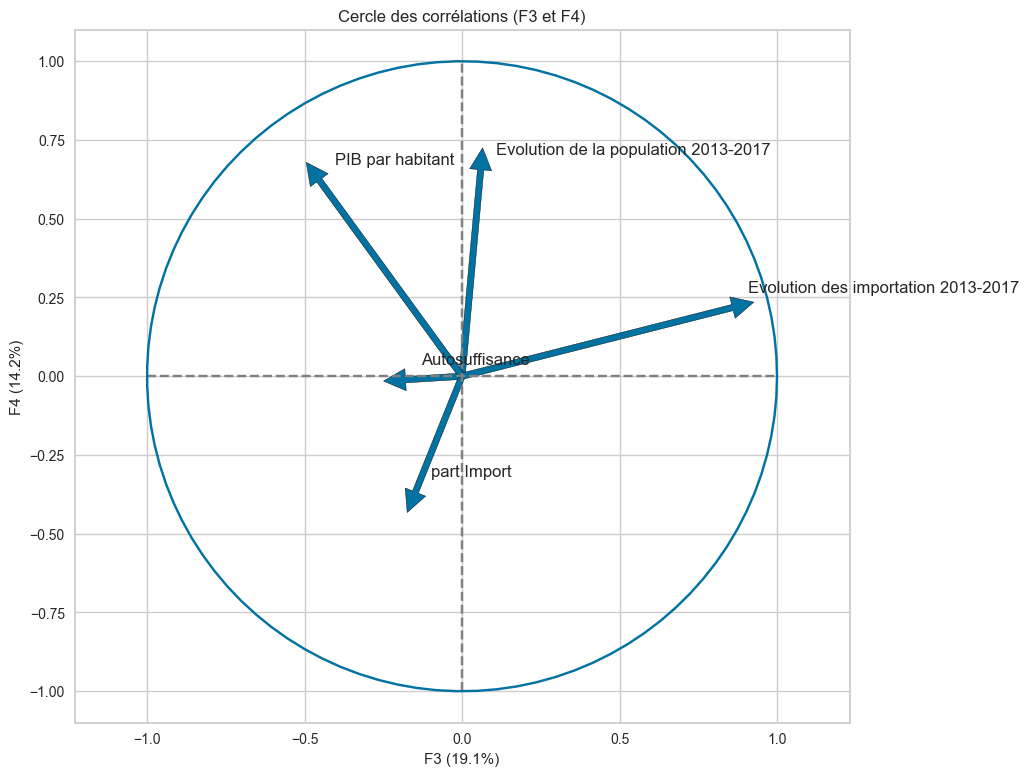

In [29]:
x_y = [2,3]

correlation_graph(pca, x_y, features)

Analyse des composantes :
- F1 : très corrélée aux imports et à l'autosuffisance
- F2 : 

In [30]:
X_proj = pca.transform(X_scaled)

In [31]:
names = df.index
clusters = df['cluster Kmeans']


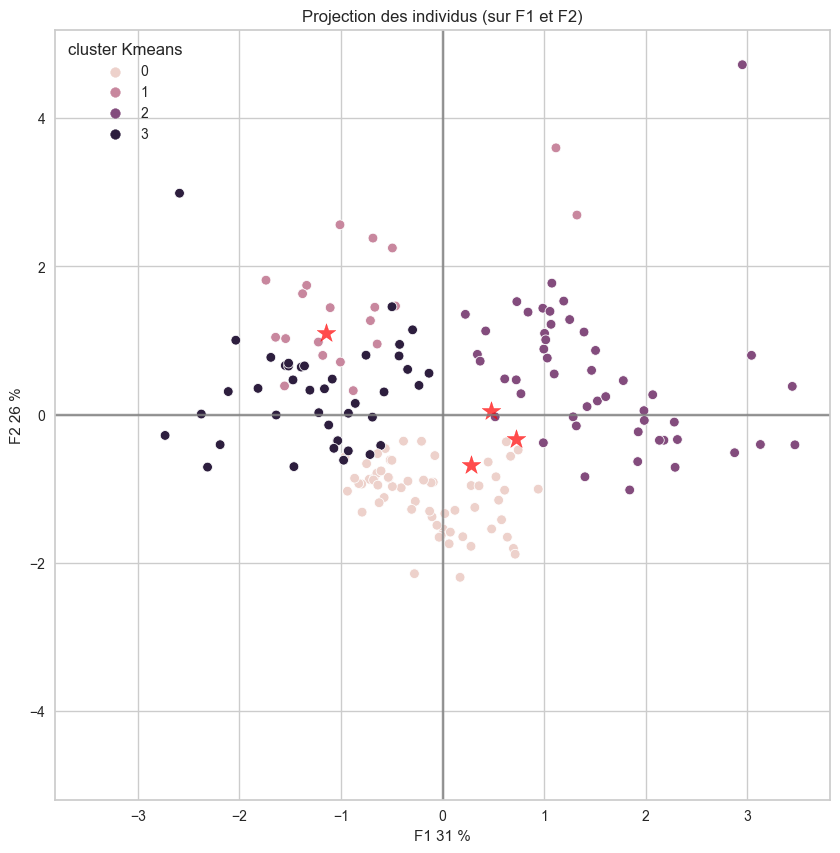

In [32]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y,pca,clusters = clusters, figsize=(10,10), marker="o")

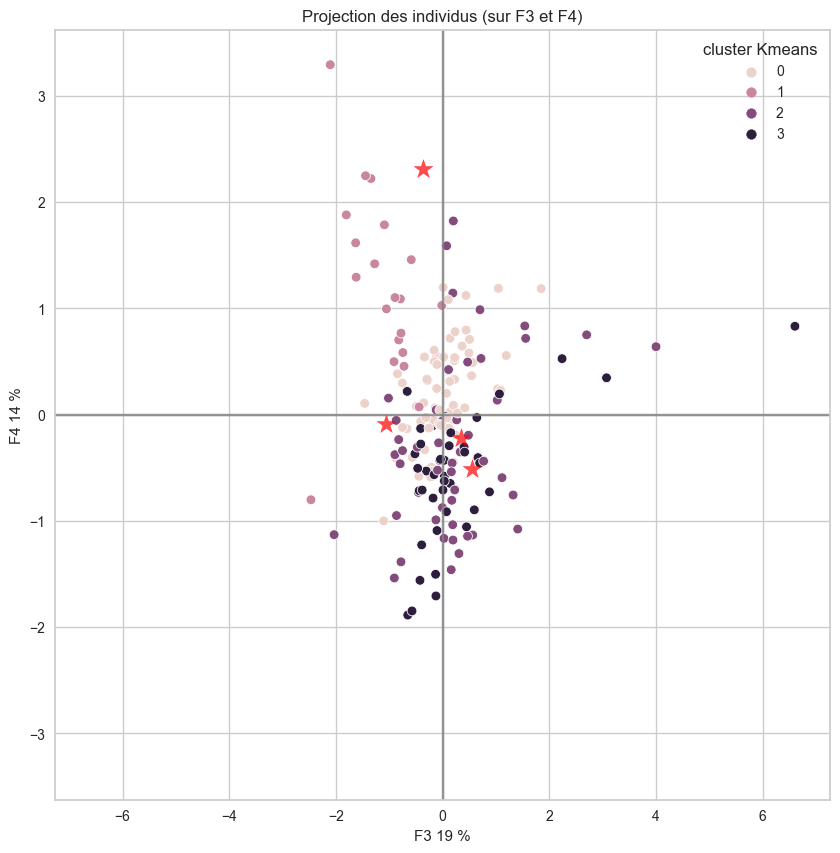

In [33]:
x_y = [2,3]
display_factorial_planes(X_proj, x_y,pca,clusters = clusters, figsize=(10,10), marker="o")

In [34]:
df.head()

,Autosuffisance,part Import,Evolution de la population 2013-2017,PIB par habitant,Evolution des importation 2013-2017,CHA Clusters,cluster Kmeans
Zone,,,,,,,
Afghanistan,49.122807,50.877193,11.093541,530.149831,24.281558,1,2
Afrique du Sud,78.706327,24.268178,5.828187,6723.928582,-11.235664,2,0
Albanie,27.659574,80.851064,-0.680300,4521.752219,27.708662,1,2
Algérie,99.277978,0.722022,7.850011,4134.936054,-0.995118,2,0
Allemagne,87.061530,48.418631,1.795391,44670.222288,-11.105807,3,1


Visualisation sur la carte

In [35]:
pays = pd.read_csv('GroupesPays.csv',sep=';')
pays=pays[["Groupe de pays", "Pays","latitude","longitude","Code ISO3"]]
listregion =  ["Asie","Afrique","Europe","Océanie","Amériques"]
pays.rename(columns={"Groupe de pays":"Région"}, inplace=True)
pays.rename(columns={"Pays":"Zone"}, inplace=True)

pays.rename(columns={"Code ISO3":"CODE"}, inplace=True)
pays = pays[pays['Région'].isin(listregion)]
df = pd.merge(df,pays, on = 'Zone', how = 'left').set_index('Zone')

In [36]:


#first let us merge geopandas data with our data 'naturalearth_lowres' is geopandas datasets so we can use it directly
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# then merge with our data 
merge=pd.merge(world,df,on='CODE',how="right")


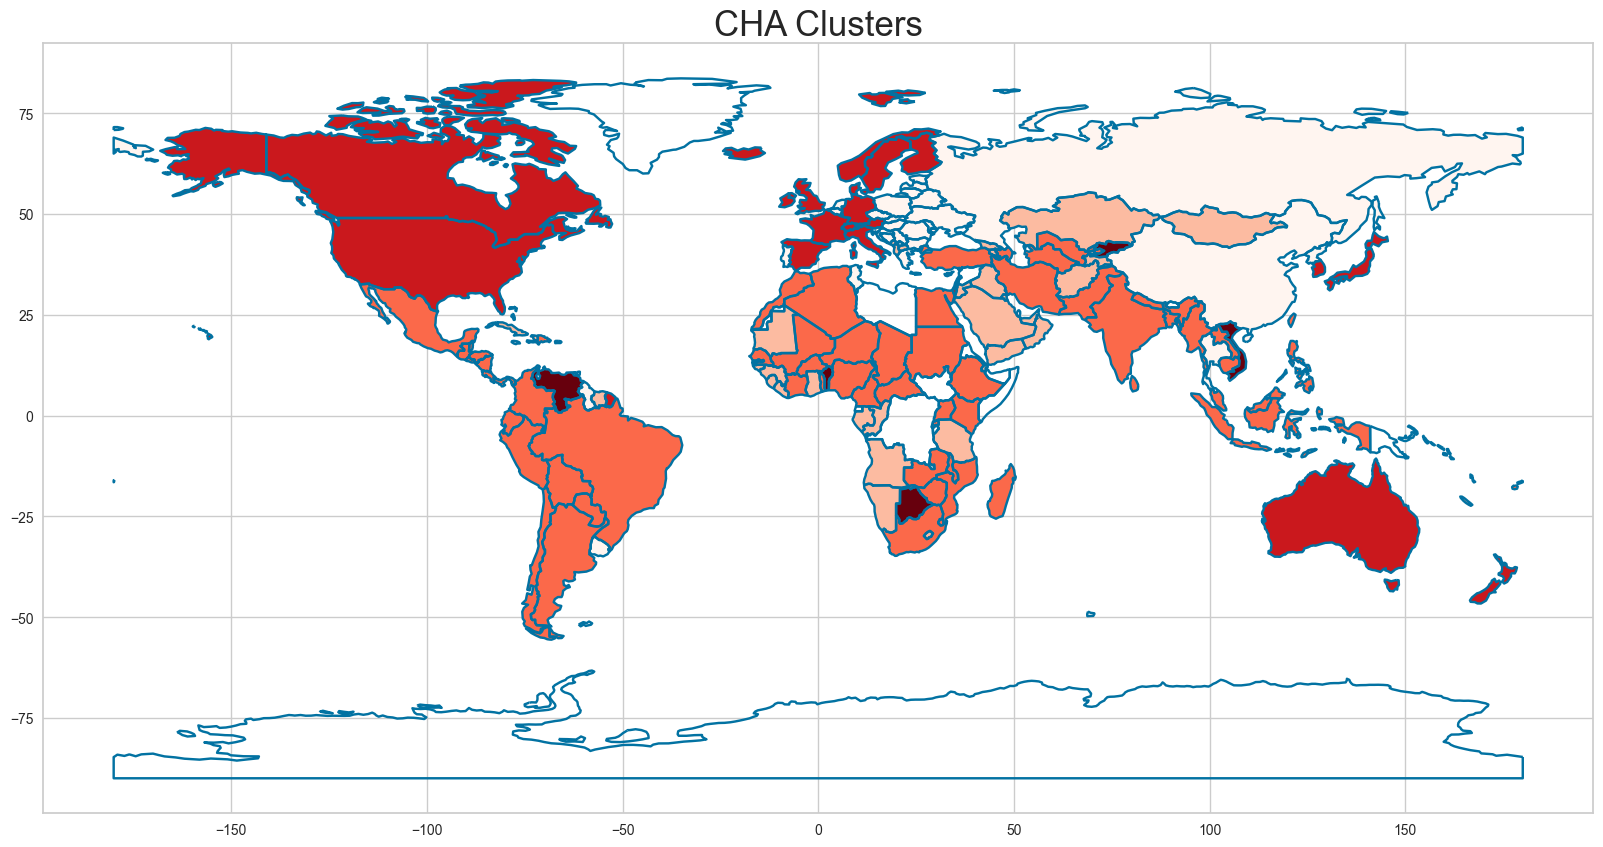

In [37]:
world_map=world["geometry"].boundary.plot(figsize=(20, 15))
world_cha=merge.plot(column='CHA Clusters',figsize=(20, 15),legend=False,cmap='Reds',ax=world_map,)


plt.title('CHA Clusters',fontsize=25)
plt.show()

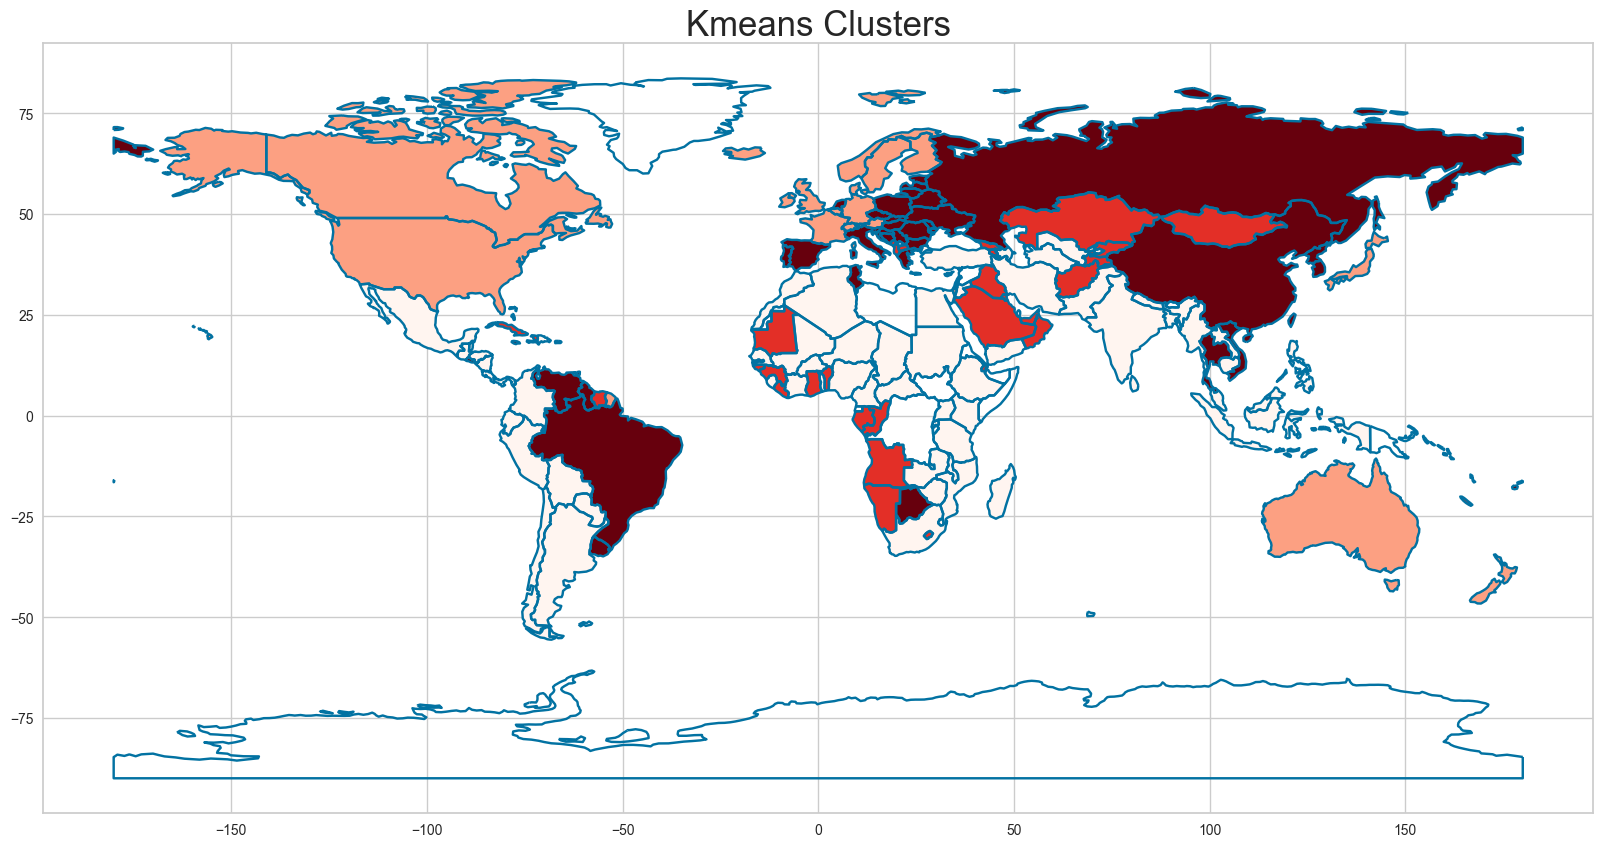

In [38]:

world_map=world["geometry"].boundary.plot(figsize=(20, 15))
world_kmeans=merge.plot(column='cluster Kmeans',legend=False,cmap='Reds',ax=world_map,figsize=(20, 15))

plt.title('Kmeans Clusters',fontsize=25)
plt.show()

In [39]:
df_full

,Autosuffisance,part Import,Population,Evolution de la population 2013-2017,Disponibilité alimentaire (Kcal/personne/jour),Part Poulet,PIB par habitant,Evolution du PIB 2013-2017,Evolution des importation 2013-2017,Evolution de la consommation 2013-2017,Index Stabilité,CHA Clusters,cluster Kmeans
Zone,,,,,,,,,,,,,
Afghanistan,49.122807,50.877193,36296113.0,11.093541,5.0,11.894273,530.149831,17.344283,24.281558,4.718645,-2.80,1,2
Afrique du Sud,78.706327,24.268178,57009756.0,5.828187,143.0,49.163763,6723.928582,10.612243,-11.235664,-6.082222,-0.28,2,0
Albanie,27.659574,80.851064,2884169.0,-0.680300,85.0,23.838538,4521.752219,-2.130179,27.708662,28.553922,0.38,1,2
Algérie,99.277978,0.722022,41389189.0,7.850011,22.0,20.061100,4134.936054,33.491244,-0.995118,-0.995950,-0.92,2,0
Allemagne,87.061530,48.418631,82658409.0,1.795391,71.0,21.790309,44670.222288,2.303657,-11.105807,-2.543802,0.59,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,11.650485,105.097087,9487203.0,3.049297,147.0,49.169435,42522.377622,4.825532,-19.677705,-20.540084,0.62,1,2
Équateur,99.706745,0.000000,16785361.0,6.421590,83.0,32.198953,6246.404252,-3.138600,0.578298,0.576923,-0.07,2,0
États-Unis d'Amérique,119.971532,0.673382,325084756.0,2.671370,219.0,39.582920,59059.596403,-10.703819,-12.611862,-12.646457,0.29,3,1


Analyse des clusters et conclusion

2 stratégies s'offrent à nous: 
- Pays à très faible autosuffisance et fort imports, mais faible stabilité politique et faible PIB par habitants
- Pays du cluster à autosuffisance un peu plus forte, moins d'import, mais stabilité politique et PIB supérieur.

Choix 1 : 

In [40]:
interet = df_full[(df_full['cluster Kmeans']==2)&(df_full['CHA Clusters']==1)]
print(f"Pays d'interet : {len(interet)}")
print(interet.index.to_list())

Pays d'interet : 46
['Afghanistan', 'Albanie', 'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Arménie', 'Bahamas', 'Cabo Verde', 'Congo', 'Cuba', 'Djibouti', 'Dominique', 'Gabon', 'Gambie', 'Ghana', 'Grenade', 'Guinée', 'Guinée-Bissau', 'Géorgie', 'Haïti', 'Iraq', 'Kazakhstan', 'Koweït', 'Lesotho', 'Libéria', 'Macédoine du Nord', 'Maldives', 'Malte', 'Mauritanie', 'Mongolie', 'Monténégro', 'Namibie', 'Nouvelle-Calédonie', 'Oman', 'Polynésie française', 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines', 'Sainte-Lucie', 'Samoa', 'Sao Tomé-et-Principe', 'Suriname', 'Tadjikistan', 'Timor-Leste', 'Vanuatu', 'Émirats arabes unis', 'Îles Salomon']


In [41]:
interet.describe()

,Autosuffisance,part Import,Population,Evolution de la population 2013-2017,Disponibilité alimentaire (Kcal/personne/jour),Part Poulet,PIB par habitant,Evolution du PIB 2013-2017,Evolution des importation 2013-2017,Evolution de la consommation 2013-2017,Index Stabilité,CHA Clusters,cluster Kmeans
count,46.000000,46.000000,4.600000e+01,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.0,46.0
mean,19.303595,98.669873,6.367690e+06,6.433455,83.826087,33.667479,8917.329399,6.236251,-11.750336,-8.524589,0.054783,1.0,2.0
std,17.663766,33.701969,1.029040e+07,4.740461,71.856432,15.447952,10142.088691,24.359475,21.861634,17.881965,0.818350,0.0,0.0
min,0.000000,50.313589,5.204500e+04,-0.997452,5.000000,2.383342,530.149831,-24.086232,-74.732449,-71.491303,-2.800000,1.0,2.0
25%,5.381242,82.123354,3.957995e+05,2.501695,28.000000,21.157697,2021.095272,-11.512681,-23.069836,-14.780739,-0.377500,1.0,2.0
50%,12.833072,95.500000,2.086765e+06,6.134868,58.000000,32.618793,4623.472794,0.145469,-10.032546,-5.710168,0.050000,1.0,2.0
75%,29.365079,102.678571,5.008578e+06,9.813625,144.250000,46.464423,9874.569742,17.661953,0.785581,0.140877,0.687500,1.0,2.0
max,75.000000,220.000000,3.755278e+07,19.312814,243.000000,65.810173,42522.377622,78.050912,27.708662,28.553922,1.250000,1.0,2.0


In [42]:
interet.sort_values('PIB par habitant', ascending=False).head(10)

,Autosuffisance,part Import,Population,Evolution de la population 2013-2017,Disponibilité alimentaire (Kcal/personne/jour),Part Poulet,PIB par habitant,Evolution du PIB 2013-2017,Evolution des importation 2013-2017,Evolution de la consommation 2013-2017,Index Stabilité,CHA Clusters,cluster Kmeans
Zone,,,,,,,,,,,,,
Émirats arabes unis,11.650485,105.097087,9487203.0,3.049297,147.0,49.169435,42522.377622,4.825532,-19.677705,-20.540084,0.62,1,2
Nouvelle-Calédonie,9.090909,81.818182,277150.0,4.657406,136.0,44.238035,32263.340715,13.805647,4.207419,-0.022314,0.00,1,2
Bahamas,23.076923,92.307692,381755.0,3.820775,182.0,45.457374,30969.876197,-11.560505,-23.830614,-1.423311,0.99,1,2
Koweït,29.629630,72.486772,4056099.0,13.059913,156.0,48.149272,29258.289478,63.245095,-1.052067,-1.165153,-0.05,1,2
Malte,28.571429,64.285714,437933.0,2.690366,103.0,31.002445,28122.287168,-14.273449,-4.451266,-5.058869,1.25,1,2
Saint-Kitts-et-Nevis,0.000000,100.000000,52045.0,3.293304,190.0,47.906281,22160.603620,-17.349207,9.361287,10.585498,0.65,1,2
Arabie saoudite,42.926829,50.313589,33101179.0,9.211515,151.0,63.733115,20138.146332,17.767843,12.461085,11.770041,-0.64,1,2
Polynésie française,6.666667,100.000000,276102.0,2.091256,167.0,35.042180,19743.958991,6.035296,-0.917811,-4.274466,0.00,1,2
Oman,6.140351,110.526316,4665928.0,19.312814,73.0,30.470685,17802.548365,32.362902,-7.343195,-5.008293,0.75,1,2


In [43]:
interet.sort_values('Autosuffisance', ascending=True).head(10)

,Autosuffisance,part Import,Population,Evolution de la population 2013-2017,Disponibilité alimentaire (Kcal/personne/jour),Part Poulet,PIB par habitant,Evolution du PIB 2013-2017,Evolution des importation 2013-2017,Evolution de la consommation 2013-2017,Index Stabilité,CHA Clusters,cluster Kmeans
Zone,,,,,,,,,,,,,
Îles Salomon,0.000000,200.000000,636039.0,10.172804,18.0,19.113924,2283.581124,-3.306453,-40.221824,-9.987411,0.20,1,2
Saint-Kitts-et-Nevis,0.000000,100.000000,52045.0,3.293304,190.0,47.906281,22160.603620,-17.349207,9.361287,10.585498,0.65,1,2
Mongolie,0.000000,111.111111,3113786.0,7.450576,9.0,2.383342,3708.248166,19.255531,-14.061449,-15.136095,0.79,1,2
Antigua-et-Barbuda,0.000000,100.000000,95426.0,4.097416,233.0,46.800105,16110.556284,-17.134152,-0.034843,10.520209,0.75,1,2
Maldives,0.000000,100.000000,496402.0,16.278943,47.0,34.737620,10063.003708,-18.289228,-13.596820,-16.554110,0.23,1,2
Saint-Vincent-et-les Grenadines,0.000000,112.500000,109827.0,1.097180,243.0,65.810173,8030.568916,-11.369208,0.591472,-1.435407,0.89,1,2
Samoa,0.000000,113.333333,195352.0,2.372128,217.0,58.706735,4246.467778,-5.973540,-10.911771,-5.404760,1.18,1,2
Djibouti,0.000000,100.000000,944099.0,6.440638,9.0,12.500000,2659.854160,-20.965669,-34.643687,-38.906129,-0.74,1,2
Dominique,0.000000,100.000000,71458.0,0.618545,150.0,49.167734,7395.991648,-2.099955,2.203441,0.621118,1.20,1,2


Choix 2 : 

In [44]:
interet2 = df_full[(df_full['cluster Kmeans']==1)&(df_full['CHA Clusters']==3)]
print(f"Pays d'interet : {len(interet2)}")
print(interet2.index.to_list())

Pays d'interet : 19
['Allemagne', 'Australie', 'Autriche', 'Canada', 'Chine - RAS de Macao', 'Danemark', 'Finlande', 'France', 'Irlande', 'Islande', 'Israël', 'Japon', 'Luxembourg', 'Norvège', 'Nouvelle-Zélande', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Suisse', 'Suède', "États-Unis d'Amérique"]


In [45]:
interet2.describe()

,Autosuffisance,part Import,Population,Evolution de la population 2013-2017,Disponibilité alimentaire (Kcal/personne/jour),Part Poulet,PIB par habitant,Evolution du PIB 2013-2017,Evolution des importation 2013-2017,Evolution de la consommation 2013-2017,Index Stabilité,CHA Clusters,cluster Kmeans
count,19.000000,19.000000,1.900000e+01,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0,19.0
mean,88.872441,38.753633,4.163691e+07,3.420792,112.157895,27.459285,58346.697736,3.691182,-6.918878,-4.667382,0.888947,3.0,1.0
std,32.434550,35.981902,7.706181e+07,2.185047,55.034598,9.972454,18983.605777,15.220766,9.909746,7.239427,0.569189,0.0,0.0
min,0.000000,0.000000,3.343930e+05,-0.636433,55.000000,16.893797,38928.952602,-30.844970,-17.145641,-12.646457,-0.890000,3.0,1.0
25%,84.753176,7.330706,5.024802e+06,1.975170,67.500000,20.433088,44102.155836,0.416626,-11.263019,-10.902468,0.730000,3.0,1.0
50%,98.883461,34.870188,8.455804e+06,2.900251,100.000000,21.790309,53788.877502,6.681388,-9.804451,-5.249734,1.050000,3.0,1.0
75%,105.980865,56.001223,5.078730e+07,4.098780,141.000000,32.644372,71226.762673,9.832472,-5.650432,-2.521388,1.215000,3.0,1.0
max,132.738095,121.052632,3.250848e+08,8.337416,234.000000,55.773464,110203.008202,36.297980,30.381188,14.856246,1.600000,3.0,1.0


In [46]:
interet2.sort_values('PIB par habitant', ascending=False).head(10)

,Autosuffisance,part Import,Population,Evolution de la population 2013-2017,Disponibilité alimentaire (Kcal/personne/jour),Part Poulet,PIB par habitant,Evolution du PIB 2013-2017,Evolution des importation 2013-2017,Evolution de la consommation 2013-2017,Index Stabilité,CHA Clusters,cluster Kmeans
Zone,,,,,,,,,,,,,
Luxembourg,0.000000,100.000000,591910.0,8.337416,69.0,16.893797,110203.008202,8.918062,-7.661156,1.479408,1.33,3,1
Suisse,68.421053,38.345865,8455804.0,4.102815,55.0,21.202221,83353.597572,5.718474,-3.159724,-4.580454,1.26,3,1
Chine - RAS de Macao,15.789474,121.052632,622585.0,7.262141,142.0,19.368490,78985.632288,9.961104,-17.145641,-1.144137,1.43,3,1
Norvège,99.019608,1.960784,5296326.0,4.094744,66.0,19.418200,75490.688450,36.297980,-5.567701,-6.096420,1.17,3,1
Islande,100.000000,20.000000,334393.0,2.154949,104.0,24.749097,71961.532046,-30.844970,-14.398968,-10.941263,1.35,3,1
Irlande,85.937500,77.343750,4753279.0,2.900251,100.0,32.749859,70491.993301,-26.339764,-12.032750,-5.950564,1.00,3,1
États-Unis d'Amérique,119.971532,0.673382,325084756.0,2.671370,219.0,39.582920,59059.596403,-10.703819,-12.611862,-12.646457,0.29,3,1
Danemark,103.592814,79.640719,5732274.0,1.642088,112.0,32.538886,57888.203512,5.509388,30.381188,14.856246,0.87,3,1
Australie,108.368915,1.366354,24584620.0,5.408695,192.0,32.258065,57430.803787,16.269737,-10.566672,-10.863674,0.90,3,1


In [47]:
interet2.sort_values('Autosuffisance', ascending=True).head(10)

,Autosuffisance,part Import,Population,Evolution de la population 2013-2017,Disponibilité alimentaire (Kcal/personne/jour),Part Poulet,PIB par habitant,Evolution du PIB 2013-2017,Evolution des importation 2013-2017,Evolution de la consommation 2013-2017,Index Stabilité,CHA Clusters,cluster Kmeans
Zone,,,,,,,,,,,,,
Luxembourg,0.000000,100.000000,591910.0,8.337416,69.0,16.893797,110203.008202,8.918062,-7.661156,1.479408,1.33,3,1
Chine - RAS de Macao,15.789474,121.052632,622585.0,7.262141,142.0,19.368490,78985.632288,9.961104,-17.145641,-1.144137,1.43,3,1
Suisse,68.421053,38.345865,8455804.0,4.102815,55.0,21.202221,83353.597572,5.718474,-3.159724,-4.580454,1.26,3,1
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,81.199642,34.870188,66727461.0,2.612782,120.0,35.729113,40617.679075,6.681388,-11.152654,-12.635524,0.39,3,1
Suède,83.957219,44.919786,9904896.0,2.896345,61.0,17.953912,53788.877502,13.070504,-9.915452,-5.249734,0.98,3,1
Autriche,85.549133,63.583815,8819901.0,2.989966,65.0,19.663954,47429.535836,6.934227,-5.733163,-4.149740,1.05,3,1
Irlande,85.937500,77.343750,4753279.0,2.900251,100.0,32.749859,70491.993301,-26.339764,-12.032750,-5.950564,1.00,3,1
Allemagne,87.061530,48.418631,82658409.0,1.795391,71.0,21.790309,44670.222288,2.303657,-11.105807,-2.543802,0.59,3,1
Japon,91.718427,44.265010,127502725.0,-0.636433,67.0,21.579732,38928.952602,4.867235,0.218626,8.617701,1.11,3,1


Ce deuxième choix semble plus intéressant. A creuser avec le métier.